# Content based movie recommendation system using machine learning
<b>Tech Used :</b> <b>python ,pandas,cosine similarity, sklearn,tfidf,countvectorizer</b>


<b>Goal:</b> To use the tmdb data sets to create a recommendation system based on the movie name or part of it that is given to the functions <code>get_recommendations</code> or <code>get_recommendations_new</code> both functions use cosine similarity; the difference is, that the first one uses a cosine silmilarity matrix that is based on the countvectorizer matrix in which it uses the data of 'keywords' ,'cast','director,'genres' of each movie as the input to it.<br>
On the other hand, the <code>get_recommendations_new</code> function uses the first methode's cosine similarity + the cosine similarty of TF-IDF vectorizer matrix which is based on the movie overview; that is a short description of the movie, which in my opinion has more accurate results as it combines both cosine similarty aspects.

In [1]:
#importing libraries
# pip install ipywidgets
#jupyter labextension install @jupyter-widgets/jupyterlab-manager
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
# from surprise import Reader, Dataset, SVD, evaluate
import json


import warnings; warnings.simplefilter('ignore')

### Data Preprocessing and EDA

In [2]:
# Open File
credits= pd.read_csv('tmdb_5000_credits.csv')
# Open File
movies= pd.read_csv('tmdb_5000_movies.csv')

In [3]:
credits.head(5)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [4]:
movies.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [5]:
#createing one big datset using the foreignkey "id"
credits.columns=['id','title','cast','crew']
movies=movies.merge(credits,on='id')

In [6]:
print("The Number of Null Values in Each Column:")
movies.isnull().sum()

The Number of Null Values in Each Column:


budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title_x                    0
vote_average               0
vote_count                 0
title_y                    0
cast                       0
crew                       0
dtype: int64

In [7]:
#droping the homepage column as it has a lot of null values and it is not relavent

trainc=movies.drop(columns=['homepage'])

In [8]:
trainc.isnull().sum()

budget                    0
genres                    0
id                        0
keywords                  0
original_language         0
original_title            0
overview                  3
popularity                0
production_companies      0
production_countries      0
release_date              1
revenue                   0
runtime                   2
spoken_languages          0
status                    0
tagline                 844
title_x                   0
vote_average              0
vote_count                0
title_y                   0
cast                      0
crew                      0
dtype: int64

In [9]:
#remove the one row which had release date as null 
trainc.drop(axis=0,index=trainc[trainc['release_date'].isnull()].index,inplace=True)


In [10]:
#replacing the runtime with the value f the runtime that has most occured
trainc['runtime'].fillna(trainc['runtime'].mode()[0],inplace=True)

In [11]:
#replacing null values with the word unknown
trainc['tagline'].fillna('unknown',inplace=True)

In [12]:
#replacing null values with empty string
trainc['overview'].fillna('',inplace=True)

In [13]:
vote_counts = trainc[trainc['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = trainc[trainc['vote_average'].notnull()]['vote_average'].astype('int')


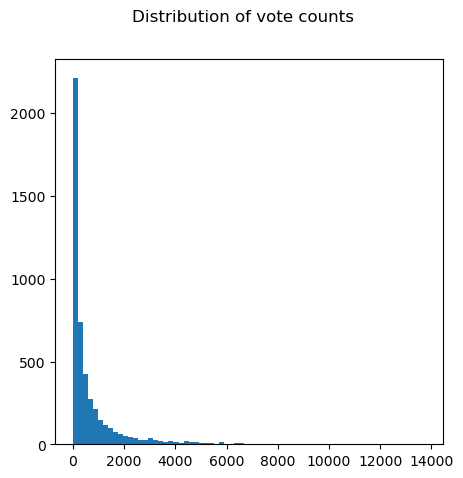

In [14]:
fig=plt.figure(figsize=(5,5))
fig.suptitle("Distribution of vote counts")
plt.hist(vote_counts,bins=70)
fig.show()

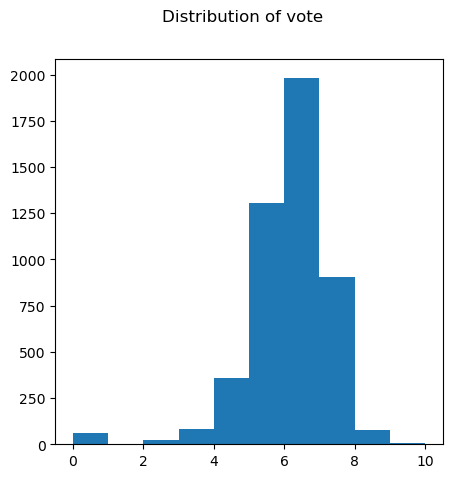

In [15]:
fig=plt.figure(figsize=(5,5))
fig.suptitle("Distribution of vote")
plt.hist(vote_averages,bins=10)
fig.show()

In [16]:
trainc["release_date"]

0       2009-12-10
1       2007-05-19
2       2015-10-26
3       2012-07-16
4       2012-03-07
           ...    
4798    1992-09-04
4799    2011-12-26
4800    2013-10-13
4801    2012-05-03
4802    2005-08-05
Name: release_date, Length: 4802, dtype: object

In [17]:
# trainc.genres = trainc.genres.fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [18]:
trainc.isnull().sum()

budget                  0
genres                  0
id                      0
keywords                0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
tagline                 0
title_x                 0
vote_average            0
vote_count              0
title_y                 0
cast                    0
crew                    0
dtype: int64

In [19]:
trainc.genres = trainc.genres.fillna('[]').apply(literal_eval)


In [20]:
trainc.keywords = trainc.keywords.fillna('[]').apply(literal_eval)


In [21]:
import re
x=re.sub(r"^('?)|('?)$" ,"",trainc.cast[0])

In [22]:
trainc.cast = trainc.cast.fillna('[]').apply(lambda x: re.sub(r"^('?)|('?)$" ,"",x)).apply(literal_eval)


In [23]:
trainc.crew = trainc.crew.fillna('[]').apply(literal_eval)


In [24]:
trainc["cast"][3]

[{'cast_id': 2,
  'character': 'Bruce Wayne / Batman',
  'credit_id': '52fe4781c3a36847f8139869',
  'gender': 2,
  'id': 3894,
  'name': 'Christian Bale',
  'order': 0},
 {'cast_id': 8,
  'character': 'Alfred Pennyworth',
  'credit_id': '52fe4781c3a36847f8139881',
  'gender': 2,
  'id': 3895,
  'name': 'Michael Caine',
  'order': 1},
 {'cast_id': 5,
  'character': 'James Gordon',
  'credit_id': '52fe4781c3a36847f8139875',
  'gender': 2,
  'id': 64,
  'name': 'Gary Oldman',
  'order': 2},
 {'cast_id': 3,
  'character': 'Selina Kyle / Catwoman',
  'credit_id': '52fe4781c3a36847f813986d',
  'gender': 1,
  'id': 1813,
  'name': 'Anne Hathaway',
  'order': 3},
 {'cast_id': 4,
  'character': 'Bane',
  'credit_id': '52fe4781c3a36847f8139871',
  'gender': 2,
  'id': 2524,
  'name': 'Tom Hardy',
  'order': 4},
 {'cast_id': 15,
  'character': 'Miranda Tate',
  'credit_id': '52fe4781c3a36847f813988d',
  'gender': 1,
  'id': 8293,
  'name': 'Marion Cotillard',
  'order': 5},
 {'cast_id': 6,
  'cha

In [25]:
#we loop through all the json values of the crew column and if the the value of the key "job" is dirctor then we will grab the value of the key "name" 
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [26]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [27]:
# Define new director, cast, genres and keywords features that are in a suitable form.
trainc['director'] = trainc['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    trainc[feature] = trainc[feature].apply(get_list)

In [28]:
trainc[['original_title', 'cast', 'director', 'keywords', 'genres']].head(3)

,original_title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [29]:
#Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''


In [30]:
# # Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    trainc[feature] = trainc[feature].apply(clean_data)

In [31]:
trainc.head(1)

,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,...,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew,director
0,237000000,"[action, adventure, fantasy]",19995,"[cultureclash, future, spacewar]",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[samworthington, zoesaldana, sigourneyweaver]","[{'credit_id': '52fe48009251416c750aca23', 'de...",jamescameron


In [32]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres']) 
trainc['soup'] = trainc.apply(create_soup, axis=1)

In [33]:
trainc['soup'][0]

'cultureclash future spacewar samworthington zoesaldana sigourneyweaver jamescameron action adventure fantasy'

In [34]:
hj=['l','p','c']
'78787'.join(hj)

'l78787p78787c'

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(trainc['soup'])

In [36]:
trainc.index

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       4793, 4794, 4795, 4796, 4797, 4798, 4799, 4800, 4801, 4802],
      dtype='int64', length=4802)

In [37]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
len(cosine_sim2[2])

4802

In [38]:
cosine_sim2

array([[1. , 0.3, 0.2, ..., 0. , 0. , 0. ],
       [0.3, 1. , 0.2, ..., 0. , 0. , 0. ],
       [0.2, 0.2, 1. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 1. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 1. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 1. ]])

In [39]:
cosine_sim2.shape

(4802, 4802)

In [40]:
klk=[[1,2,3],
     [3,2,1],
     [1,2,3]]
klk=np.array(klk)
klk.shape
klk[2][2]

3

In [41]:
# Reset index of our main DataFrame and construct reverse mapping as before
trainc = trainc.reset_index()
indices = pd.Series(trainc.index, index=trainc['original_title'])

In [42]:
indices['Spectre']

2

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
trainc['overview'] = trainc['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(trainc['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4802, 20977)

In [44]:
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [45]:
cosine_sim.shape

(4802, 4802)

In [46]:
def ge(ind):
    b=[]
    for i in  ind :
        print( trainc['genres'].iloc[i])
ge([5,8,9])

['fantasy', 'action', 'adventure']
['adventure', 'fantasy', 'family']
['action', 'adventure', 'fantasy']


In [47]:
trainc[trainc['vote_average']>
5]

,index,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,...,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew,director,soup
0,0,237000000,"[action, adventure, fantasy]",19995,"[cultureclash, future, spacewar]",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[samworthington, zoesaldana, sigourneyweaver]","[{'credit_id': '52fe48009251416c750aca23', 'de...",jamescameron,cultureclash future spacewar samworthington zo...
1,1,300000000,"[adventure, fantasy, action]",285,"[ocean, drugabuse, exoticisland]",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[johnnydepp, orlandobloom, keiraknightley]","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",goreverbinski,ocean drugabuse exoticisland johnnydepp orland...
2,2,245000000,"[action, adventure, crime]",206647,"[spy, basedonnovel, secretagent]",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[danielcraig, christophwaltz, léaseydoux]","[{'credit_id': '54805967c3a36829b5002c41', 'de...",sammendes,spy basedonnovel secretagent danielcraig chris...
3,3,250000000,"[action, crime, drama]",49026,"[dccomics, crimefighter, terrorist]",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[christianbale, michaelcaine, garyoldman]","[{'credit_id': '52fe4781c3a36847f81398c3', 'de...",christophernolan,dccomics crimefighter terrorist christianbale ...
4,4,260000000,"[action, adventure, sciencefiction]",49529,"[basedonnovel, mars, medallion]",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[taylorkitsch, lynncollins, samanthamorton]","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de...",andrewstanton,basedonnovel mars medallion taylorkitsch lynnc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4797,4798,220000,"[action, crime, thriller]",9367,"[unitedstates–mexicobarrier, legs, arms]",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]",...,Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238,El Mariachi,"[carlosgallardo, jaimedehoyos, petermarquardt]","[{'credit_id': '52fe44eec3a36847f80b280b', 'de...",robertrodriguez,unitedstates–mexicobarrier legs arms carlosgal...
4798,4799,9000,"[comedy, romance]",72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],...,Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5,Newlyweds,"[edwardburns, kerrybishé, marshadietlein]","[{'credit_id': '52fe487dc3a368484e0fb013', 'de...",edwardburns,edwardburns kerrybishé marshadietlein edwardb...
4799,4800,0,"[comedy, drama, romance]",231617,"[date, loveatfirstsight, narration]",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""id"": 3958}...",...,Released,unknown,"Signed, Sealed, Delivered",7.0,6,"Signed, Sealed, Delivered","[ericmabius, kristinbooth, crystallowe]","[{'credit_id': '52fe4df3c3a36847f8275ecf', 'de...",scottsmith,date loveatfirstsight narration ericmabius kri...
4800,4801,0,[],12618

In [48]:
b=indices.reset_index()
b.drop(axis=0,columns=b.columns[-1],inplace=True)
b

,original_title
0,Avatar
1,Pirates of the Caribbean: At World's End
2,Spectre
3,The Dark Knight Rises
4,John Carter
...,...
4797,El Mariachi
4798,Newlyweds
4799,"Signed, Sealed, Delivered"
4800,Shanghai Calling


In [49]:
cosine_sim[9][3]

0.13376515592955956

### Preparing data for Interactive Search Engine

In [50]:
trainc['year'] = pd.to_datetime(trainc['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [51]:
trainc

,index,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,...,tagline,title_x,vote_average,vote_count,title_y,cast,crew,director,soup,year
0,0,237000000,"[action, adventure, fantasy]",19995,"[cultureclash, future, spacewar]",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[samworthington, zoesaldana, sigourneyweaver]","[{'credit_id': '52fe48009251416c750aca23', 'de...",jamescameron,cultureclash future spacewar samworthington zo...,2009
1,1,300000000,"[adventure, fantasy, action]",285,"[ocean, drugabuse, exoticisland]",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[johnnydepp, orlandobloom, keiraknightley]","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",goreverbinski,ocean drugabuse exoticisland johnnydepp orland...,2007
2,2,245000000,"[action, adventure, crime]",206647,"[spy, basedonnovel, secretagent]",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[danielcraig, christophwaltz, léaseydoux]","[{'credit_id': '54805967c3a36829b5002c41', 'de...",sammendes,spy basedonnovel secretagent danielcraig chris...,2015
3,3,250000000,"[action, crime, drama]",49026,"[dccomics, crimefighter, terrorist]",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[christianbale, michaelcaine, garyoldman]","[{'credit_id': '52fe4781c3a36847f81398c3', 'de...",christophernolan,dccomics crimefighter terrorist christianbale ...,2012
4,4,260000000,"[action, adventure, sciencefiction]",49529,"[basedonnovel, mars, medallion]",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[taylorkitsch, lynncollins, samanthamorton]","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de...",andrewstanton,basedonnovel mars medallion taylorkitsch lynnc...,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4797,4798,220000,"[action, crime, thriller]",9367,"[unitedstates–mexicobarrier, legs, arms]",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]",...,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238,El Mariachi,"[carlosgallardo, jaimedehoyos, petermarquardt]","[{'credit_id': '52fe44eec3a36847f80b280b', 'de...",robertrodriguez,unitedstates–mexicobarrier legs arms carlosgal...,1992
4798,4799,9000,"[comedy, romance]",72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],...,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5,Newlyweds,"[edwardburns, kerrybishé, marshadietlein]","[{'credit_id': '52fe487dc3a368484e0fb013', 'de...",edwardburns,edwardburns kerrybishé marshadietlein edwardb...,2011
4799,4800,0,"[comedy, drama, romance]",231617,"[date, loveatfirstsight, narration]",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""id"": 3958}...",...,unknown,"Signed, Sealed, Delivered",7.0,6,"Signed, Sealed, Delivered","[ericmabius, kristinbooth, crystallowe]","[{'credit_id': '52fe4df3c3a36847f8275ecf', 'de...",scottsmith,date loveatfirstsight narration ericmabius kri...,2013
4800,4801,0,[],126186,[],en,Shanghai Calling,When ambi

In [52]:
trainc.isnull().sum()

index                   0
budget                  0
genres                  0
id                      0
keywords                0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
tagline                 0
title_x                 0
vote_average            0
vote_count              0
title_y                 0
cast                    0
crew                    0
director                0
soup                    0
year                    0
dtype: int64

In [53]:
trainc.shape

(4802, 26)

In [54]:
#add the Release Year to the movie title to create a search engine using jupyter notebook widgets.
trainc["original_title"]=trainc['original_title']+" "+trainc["year"]

In [55]:
trainc["original_title"][0]

'Avatar 2009'

In [56]:
import re

def clean_title(title):
    title = re.sub("[^a-zA-Z0-9 ]", "", title)
    title=title.lower()
    return title

In [57]:
trainc["cleaned_title"]=trainc["original_title"].apply(clean_title)

In [58]:
trainc.cleaned_title

0                                       avatar 2009
1       pirates of the caribbean at worlds end 2007
2                                      spectre 2015
3                        the dark knight rises 2012
4                                  john carter 2012
                           ...                     
4797                               el mariachi 1992
4798                                 newlyweds 2011
4799                   signed sealed delivered 2013
4800                          shanghai calling 2012
4801                         my date with drew 2005
Name: cleaned_title, Length: 4802, dtype: object

In [59]:
#this will take the title as sets of two words (bag of 2)
vectorizer = TfidfVectorizer(ngram_range=(1,2))

tfidf = vectorizer.fit_transform(trainc["cleaned_title"])

In [60]:
#search engine alorithm
def search(title):
    #we clean the title that the user will input in the field
    title = clean_title(title)
    #we transform it using the tf-idf vectorizor
    query_vec = vectorizer.transform([title])
    #computing the cosine sim between the vector of the user title and the tfidf matrix 
    similarity = cosine_similarity(query_vec, tfidf).flatten()
    
    # indices = np.argpartition(similarity, -5)[-5:]
    indices=list(enumerate(similarity))
    indices=sorted(indices,reverse=True,key=lambda x : x[1])
    indices=[i[0] for i in indices[:5]]
    results = trainc[['index','original_title','cleaned_title', 'cast', 'director', 'keywords', 'genres']].iloc[indices]
    
    return results

In [61]:
search("Toy Story 1995")
# [4760 3309   42 1541  343]


,index,original_title,cleaned_title,cast,director,keywords,genres
1541,1541,Toy Story 1995,toy story 1995,"[tomhanks, timallen, donrickles]",johnlasseter,"[jealousy, toy, boy]","[animation, comedy, family]"
42,42,Toy Story 3 2010,toy story 3 2010,"[tomhanks, timallen, nedbeatty]",leeunkrich,"[hostage, college, toy]","[animation, family, comedy]"
343,343,Toy Story 2 1999,toy story 2 1999,"[tomhanks, timallen, joancusack]",johnlasseter,"[museum, prosecution, identitycrisis]","[animation, comedy, family]"
3309,3309,紅番區 1995,1995,"[jackiechan, anitamui, françoiseyip]",stanleytong,"[newyork, martialarts, supermarket]","[crime, action, comedy]"
4760,4761,A True Story 2013,a true story 2013,"[katrinabowden, jongries, malcolmgoodwin]",malcolmgoodwin,[],[comedy]


In [62]:
#using interactive widgets and tfidf to get the most similar movie to the searched title and date
import ipywidgets as widgets
from IPython.display import display
layout = widgets.Layout(width='auto', height='40px') #set width and height

movie_input = widgets.Text(
    description='Movie Title Date(Must be more than 5 chars):',
    disabled=False, 
    display='flex', 
    layout = layout,
    style= {'description_width': 'initial'}
)
movie_list = widgets.Output()

def on_type(data):
    with movie_list:
        movie_list.clear_output()
        title = data["new"]
        if len(title) > 5:
            display(search(title))

movie_input.observe(on_type, names='value')


display(movie_input, movie_list)

Text(value='', description='Movie Title Date(Must be more than 5 chars):', layout=Layout(height='40px', width=…

Output()

### Recommedation system algorithm

In [63]:
from sklearn.metrics.pairwise import cosine_similarity

from scipy import spatial

def Similarity(movieId1, movieId2):
    
    return  cosine_sim[movieId1][movieId2]

In [64]:
# def similarity_round_2(movieidx1,movieidx2):
#     a = trainc.iloc[movieidx1]
#     b = trainc.iloc[movieidx2]
#     max=int(trainc['year'].max())
#     # min=int(trainc['year'].min())
#     yearA = int(a['year'])/max
#     yearB = int(b['year'])/max
#     yearDistance = np.absolute(yearA-yearB)
#     max_rating=trainc['weighted_rating'].max()
#     # min_rating=trainc['weighted_rating'].min()
#     # range_rating=max_rating-min_rating
#     weighted_ratingA = a['weighted_rating']/max_rating
#     weighted_ratingB = b['weighted_rating']/max_rating
#     weighted_ratingDistance = np.absolute(weighted_ratingA - weighted_ratingB)
#     return (weighted_ratingDistance + yearDistance)/2

In [65]:
import operator

def predictor(name):
    t=b[b["original_title"].str.lower().str.contains(str(name).lower())]["original_title"].values[0]
    idx = indices[t]
    new_movie=trainc.iloc[idx]
    print(f'''movies similar to index : {idx} "title": {trainc['original_title'].iloc[idx] }//"genres":{trainc['genres'].iloc[idx]}//"cast":{trainc['cast'].iloc[idx]}//'director':{trainc['director'].iloc[idx]}//'keyword':{trainc['keywords'].iloc[idx]}//"vote_average":{trainc['vote_average'].iloc[idx]}//"year":{trainc['year'].iloc[idx]} are:''')
    def getNeighbors1(idx):
        distances = []
    
        for index, movie in trainc.iterrows():
            if index != idx:
                dist = Similarity(index, idx)
                distances.append((index, dist))
    
        distances= sorted(distances, key=lambda x: x[1], reverse=True)
        return distances[0:11]
    
        
    neighbors = getNeighbors1(idx)
    # movie_indices= [i[0] for i in neighbors]
    # movie_sim = [i[1] for i in neighbors]
    # new_trainc=trainc[trainc.index.isin(movie_indices)]
    # print(len(new_trainc))
    # def getneighbors2(idx):
    #     distances = []
    
    #     for index, movie in new_trainc.iterrows():
    #         if index != idx:
    #             dist = similarity_round_2(index, idx)
    #             distances.append((index, dist))
    
    #     distances= sorted(distances, key=lambda x: x[1], reverse=True)
    #     return distances[0:11]
    # neighbors = getneighbors2(idx)
    print('\nRecommended movies: \n')
    movie_indices= [i[0] for i in neighbors]
    movie_sim = [i[1] for i in neighbors]
    
        
        
    ko={"title":trainc['original_title'].iloc[movie_indices] ,"genres":trainc['genres'].iloc[movie_indices],"cast":trainc['cast'].iloc[movie_indices],'director':trainc['director'].iloc[movie_indices],'keyword':trainc['keywords'].iloc[movie_indices],'overview':trainc['overview'].iloc[movie_indices],'similarity':[1-i for i in movie_sim],"vote_average":trainc['vote_average'].iloc[movie_indices],"year":trainc['year'].iloc[movie_indices]}
    dms=pd.DataFrame(ko)
    return dms

In [66]:
predictor("Spider-man")

movies similar to index : 5 "title": Spider-Man 3 2007//"genres":['fantasy', 'action', 'adventure']//"cast":['tobeymaguire', 'kirstendunst', 'jamesfranco']//'director':samraimi//'keyword':['dualidentity', 'amnesia', 'sandstorm']//"vote_average":5.9//"year":2007 are:

Recommended movies: 



,title,genres,cast,director,keyword,overview,similarity,vote_average,year
159,Spider-Man 2002,"[fantasy, action]","[tobeymaguire, willemdafoe, kirstendunst]",samraimi,"[lossoflover, spider, thanksgiving]",After being bitten by a genetically altered sp...,0.717310,6.8,2002
30,Spider-Man 2 2004,"[action, adventure, fantasy]","[tobeymaguire, kirstendunst, jamesfranco]",samraimi,"[dualidentity, loveofone'slife, pizzaboy]",Peter Parker is going through a major identity...,0.753519,6.7,2004
1534,Arachnophobia 1990,"[comedy, horror]","[jeffdaniels, harleyjanekozak, garetteratliffh...",frankmarshall,"[smalltown, outbreak, exterminator]",A large spider from the jungles of South Ameri...,0.763295,6.2,1990
20,The Amazing Spider-Man 2012,"[action, adventure, fantasy]","[andrewgarfield, emmastone, rhysifans]",marcwebb,"[lossoffather, vigilante, serum]",Peter Parker is an outcast high schooler aband...,0.777149,6.5,2012
38,The Amazing Spider-Man 2 2014,"[action, adventure, fantasy]","[andrewgarfield, emmastone, jamiefoxx]",marcwebb,"[obsession, marvelcomic, sequel]","For Peter Parker, life is busy. Between taking...",0.788595,6.5,2014
1318,The Thing 1982,"[horror, mystery, sciencefiction]","[kurtrussell, keithdavid, wilfordbrimley]",johncarpenter,"[ice, spacemarine, paranoia]",Scientists in the Antarctic are confronted by ...,0.828334,7.8,1982
4663,Bronson 2008,"[drama, action, crime]","[tomhardy, mattking, jameslance]",nicolaswindingrefn,"[prison, isolation]",A young man who was sentenced to 7 years in pr...,0.898811,6.9,2008
3610,Not Easily Broken 2009,"[drama, romance]","[morrischestnut, tarajip.henson, maevequinlan]",billduke,[],A car accident and shifting affections test th...,0.903017,6.3,2009
4456,Raising Victor Vargas 2002,"[drama, romance]","[victorrasuk, judymarte, meloniediaz]",petersollett,[independentfilm],"The film follows Victor, a Lower East Side tee...",0.905590,7.8,2002
4276,Def-Con 4 1985,[sciencefiction],"[lenorezann, maurychaykin, katelynch]",pauldonovan,"[post-apocalyptic, dystopia, canuxploitation]",Two men and a woman circle the globe in a sate...,0.905768,2.8,1985


In [67]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    t=b[b["original_title"].str.lower().str.contains(str(title).lower())]["original_title"].values[0]
    idx = indices[t]

    # Get the pairwsie similarity scores of all movies with that movie
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    #cosformovies
    movie_sim = [i[1] for i in sim_scores]
    # Return the top 10 most similar movies
    ko={"title":trainc['original_title'].iloc[movie_indices] ,"genres":trainc['genres'].iloc[movie_indices],"cast":trainc['cast'].iloc[movie_indices],'director':trainc['director'].iloc[movie_indices],'keyword':trainc['keywords'].iloc[movie_indices],'overview':trainc['overview'].iloc[movie_indices],'similarity':movie_sim,"vote_average":trainc['vote_average'].iloc[movie_indices],"year":trainc['year'].iloc[movie_indices]}
    dms=pd.DataFrame(ko)
    print(f'''movies similar to index : {idx} "title": {trainc['original_title'].iloc[idx] }//"genres":{trainc['genres'].iloc[idx]}//"cast":{trainc['cast'].iloc[idx]}//'director':{trainc['director'].iloc[idx]}//'keyword':{trainc['keywords'].iloc[idx]}//"vote_average":{trainc['vote_average'].iloc[idx]}//"year":{trainc['year'].iloc[idx]} are:''')
    dms.vote_average.mean()
    
    return dms

In [68]:
#based on 'cast', 'keywords', 'director', 'genres'
#i included the title of the movie itself in order for the user to compair
get_recommendations("Superman")


movies similar to index : 9 "title": Batman v Superman: Dawn of Justice 2016//"genres":['action', 'adventure', 'fantasy']//"cast":['benaffleck', 'henrycavill', 'galgadot']//'director':zacksnyder//'keyword':['dccomics', 'vigilante', 'superhero']//"vote_average":5.7//"year":2016 are:


,title,genres,cast,director,keyword,overview,similarity,vote_average,year
428,Batman Returns 1992,"[action, fantasy]","[michaelkeaton, dannydevito, michellepfeiffer]",timburton,"[holiday, corruption, doublelife]","Having defeated the Joker, Batman now faces th...",0.142000,6.6,1992
3,The Dark Knight Rises 2012,"[action, crime, drama]","[christianbale, michaelcaine, garyoldman]",christophernolan,"[dccomics, crimefighter, terrorist]",Following the death of District Attorney Harve...,0.133765,7.6,2012
3819,Defendor 2009,"[drama, action, comedy]","[woodyharrelson, katdennings, eliaskoteas]",peterstebbings,"[crimefighter, delusion, superhero]","A crooked cop, a mob boss and the young girl t...",0.129537,6.5,2009
1359,Batman 1989,"[fantasy, action]","[jacknicholson, michaelkeaton, kimbasinger]",timburton,"[doublelife, dccomics, dualidentity]",The Dark Knight of Gotham City begins his war ...,0.126639,7.0,1989
2608,Black Snake Moan 2006,[drama],"[samuell.jackson, christinaricci, justintimber...",craigbrewer,"[southernusa, blues, militaryservice]",A God-fearing bluesman takes to a wild young w...,0.123029,6.6,2006
65,The Dark Knight 2008,"[drama, action, crime]","[christianbale, heathledger, aaroneckhart]",christophernolan,"[dccomics, crimefighter, secretidentity]",Batman raises the stakes in his war on crime. ...,0.118648,8.2,2008
3854,"Batman: The Dark Knight Returns, Part 2 2013","[action, animation]","[peterweller, arielwinter, davidselby]",jayoliva,"[dccomics, future, joker]",Batman has stopped the reign of terror that Th...,0.111923,7.9,2013
1720,Kick-Ass 2010,"[action, crime]","[aarontaylor-johnson, chloëgracemoretz, christ...",matthewvaughn,"[crimefighter, secretidentity, comicbook]",Dave Lizewski is an unnoticed high school stud...,0.110878,7.1,2010
14,Man of Steel 2013,"[action, adventure, fantasy]","[henrycavill, amyadams, michaelshannon]",zacksnyder,"[savingtheworld, dccomics, superhero]",A young boy learns that he has extraordinary p...,0.110571,6.5,2013
795,Leatherheads 2008,"[comedy, romance, drama]","[georgeclooney, renéezellweger, johnkrasinski]",georgeclooney,"[americanfootball, sportsteam, stadium]",A light hearted comedy about the beginnings of...,0.108223,5.7,2008


In [69]:
#based on 'overview'
get_recommendations('the Mask', cosine_sim)

movies similar to index : 309 "title": Son of the Mask 2005//"genres":['fantasy', 'comedy', 'family']//"cast":['jamiekennedy', 'alancumming', 'traylorhoward']//'director':lawrenceguterman//'keyword':['baby', 'mask', 'viking']//"vote_average":3.6//"year":2005 are:


,title,genres,cast,director,keyword,overview,similarity,vote_average,year
2313,The Mask 1994,"[romance, comedy, crime]","[jimcarrey, camerondiaz, nancyfish]",chuckrussell,"[dualidentity, bank, mockery]",When timid bank clerk Stanley Ipkiss discovers...,0.231943,6.6,1994
4011,Halloween III: Season of the Witch 1982,"[horror, mystery, sciencefiction]","[tomatkins, staceynelkin, dano'herlihy]",tommyleewallace,"[commercial, factory, gasstation]",Dr. Daniel Challis and Ellie Grimbridge stumbl...,0.149713,5.0,1982
1206,The Odd Life of Timothy Green 2012,"[fantasy, drama, comedy]","[jennifergarner, joeledgerton, ronlivingston]",peterhedges,"[green, dodgeball, incredibile]",A childless couple bury a box in their backyar...,0.139400,6.5,2012
623,Dinner for Schmucks 2010,[comedy],"[stevecarell, paulrudd, stephanieszostak]",jayroach,"[mouse, idiot, mindcontrol]",Rising executive Tim Wagner works for a boss w...,0.114151,5.5,2010
2862,About Time 2013,"[comedy, drama, sciencefiction]","[domhnallgleeson, rachelmcadams, billnighy]",richardcurtis,"[londonengland, fathersonrelationship, timetra...",The night after another unsatisfactory New Yea...,0.109513,7.8,2013
2892,Darling Companion 2012,"[drama, romance]","[dianekeaton, kevinkline, samshepard]",lawrencekasdan,[aftercreditsstinger],The story of a woman who loves her dog more th...,0.109416,5.3,2012
3368,Outside Providence 1999,"[romance, comedy, drama]","[shawnhatosy, amysmart, alecbaldwin]",michaelcorrente,"[suicide, sex, sexuality]","In this coming-of-age comedy, Tim Dunphy is le...",0.100298,5.6,1999
2997,The Boy 2016,"[horror, mystery, thriller]","[laurencohan, rupertevans, jamesrussell]",williambrentbell,"[suicide, england, fire]","A nanny, working for a family whose son has ju...",0.095318,5.8,2016
2117,Boogeyman 2005,"[thriller, horror, drama]","[emilydeschanel, barrywatson, skyemccolebartus...",stephent.kay,"[nightmare, hallucination, childhoodtrauma]",Every culture has one – the horrible monster f...,0.083333,4.6,2005
452,Space Jam 1996,"[animation, comedy, drama]","[michaeljordan, wayneknight, billywest]",joepytka,"[sport, basketball, doctor]",In a desperate attempt to win a basketball mat...,0.081592,6.5,1996


In [70]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations_new(idx):
    # Get the index of the movie that matches the title
    # t=b[b["original_title"].str.lower().str.contains(str(title).lower())]["original_title"].values[0]
    # idx = indices[t]

    # Get the pairwsie similarity scores of all movies with that movie
    
    sim_scores = list(enumerate((cosine_sim[idx]+cosine_sim2[idx])/2))
    
    

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    #cosformovies
    movie_sim = [i[1] for i in sim_scores]
    # Return the top 10 most similar movies
    ko={"title":trainc['cleaned_title'].iloc[movie_indices] ,"genres":trainc['genres'].iloc[movie_indices],"cast":trainc['cast'].iloc[movie_indices],'director':trainc['director'].iloc[movie_indices],'keyword':trainc['keywords'].iloc[movie_indices],'overview':trainc['overview'].iloc[movie_indices],'similarity':movie_sim,"vote_average":trainc['vote_average'].iloc[movie_indices]}
    dms=pd.DataFrame(ko)
    return dms

In [73]:


layout = widgets.Layout(width='auto', height='40px') #set width and height

movie_input = widgets.Text(
    description='Movie Title Date(Must be more than 5 chars):',
    disabled=False, 
    display='flex', 
    layout = layout,
    style= {'description_width': 'initial'}
)
recommendation_list = widgets.Output()

def on_type(data):
    with recommendation_list:
        recommendation_list.clear_output()
        title = data["new"]
        if len(title) > 5:
            results = search(title)
            movie_id = results.iloc[0][0]
            display(get_recommendations_new(movie_id))

movie_input.observe(on_type, names='value')

display(movie_input, recommendation_list)

Text(value='', description='Movie Title Date(Must be more than 5 chars):', layout=Layout(height='40px', width=…

Output()